# Ciencia de Datos. TP3: Técnicas de Machine Learning

Axel Maddonni, LU 200/14 <br>
Federico Patane, LU 683/10<br>


*Octubre 2017*

***

### Obtención de Features

Usando las funciones programadas en el trabajo anterior, se extraen los features a partir de los datos de EEG de 20 pacientes y se almacenan en una variable *features*. A partir de los 24 features obtenidos se aplicarán técnicas de Machine Learning para intentar clasificar pacientes con capacidades cognitivas normales (Grupo S) y con capacidades cognitivas severamente disminuidas (Grupo P).

In [21]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as sps
import scipy.io as sio
%matplotlib inline
matplotlib.style.use('ggplot')
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn import  linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import math

In [1]:
def convertToDataFrame(data):
    epochs, electrodos, tiempos =  data.shape
    data = data.reshape((electrodos*epochs, tiempos))

    l1 = []
    l2 = []
    datos = []
    for x in range(0, electrodos) : 
        for y in range(0, epochs) : 
            l1.append(x)
            l2.append(y)

    l =  [l1,l2]
    tuples = list(zip(*l))

    index = pd.MultiIndex.from_tuples(tuples, names=['electrodos', 'epochs'])

    return pd.DataFrame(data, index=index)

def dataEpochs(df):
    return df.shape[0] / electrodos

electrodos, tiempos =  256, 201

In [3]:
dfs = [
    convertToDataFrame(sio.loadmat('P01.mat')['data']),
    convertToDataFrame(sio.loadmat('P02.mat')['data']),
    convertToDataFrame(sio.loadmat('P03.mat')['data']),
    convertToDataFrame(sio.loadmat('P04.mat')['data']),
    convertToDataFrame(sio.loadmat('P05.mat')['data']),
    convertToDataFrame(sio.loadmat('P06.mat')['data']),
    convertToDataFrame(sio.loadmat('P07.mat')['data']),
    convertToDataFrame(sio.loadmat('P08.mat')['data']),  
    convertToDataFrame(sio.loadmat('P09.mat')['data']),
    convertToDataFrame(sio.loadmat('P10.mat')['data']),
    convertToDataFrame(sio.loadmat('S01.mat')['data']),
    convertToDataFrame(sio.loadmat('S02.mat')['data']),
    convertToDataFrame(sio.loadmat('S03.mat')['data']),
    convertToDataFrame(sio.loadmat('S04.mat')['data']),
    convertToDataFrame(sio.loadmat('S05.mat')['data']),
    convertToDataFrame(sio.loadmat('S06.mat')['data']),
    convertToDataFrame(sio.loadmat('S07.mat')['data']),
    convertToDataFrame(sio.loadmat('S08.mat')['data']),
    convertToDataFrame(sio.loadmat('S09.mat')['data']),
    convertToDataFrame(sio.loadmat('S10.mat')['data']) ]

In [19]:
def get_espectro(frecuencia, potencia):
    delta, theta, alpha, beta, gamma = 0, 0, 0, 0, 0
    i = 0
    while i < len(frecuencia) : 
        if frecuencia[i] < 4 : 
            delta += potencia[i]
        else : 
            if frecuencia[i] >= 4 and frecuencia[i] < 8 :
                theta += potencia[i]
            else : 
                if frecuencia[i] >= 8 and frecuencia[i] < 13 :
                    alpha += potencia[i]
                else : 
                    if frecuencia[i] >= 13 and frecuencia[i] < 30 :
                        beta += potencia[i]
                    else : 
                        gamma += potencia[i]
        i = i + 1
    return delta , theta , alpha , beta , gamma

def calcularBandasDeFrecuenciaMedia(data, paciente):
    deltaProm , thetaProm , alphaProm , betaProm , gammaProm = [], [], [], [], []
    bandas = []
    for e in (8,44,80,131,185):
        for i in range(0, dataEpochs(data)):
            f, Pxx_den = sps.welch(data.loc[e,i], fs=250)
            delta , theta , alpha , beta , gamma = get_espectro(f , Pxx_den)
            bandas.append(np.asarray([delta, theta, alpha, beta, gamma]))
    bandas = np.asarray(bandas).mean(axis=0)
    return bandas

n = 1
bandasFrecuenciaMedia = []
bandasFrecuenciaStd = []
bandasFrecuenciaNormMedia = []
bandasFrecuenciaNormStd = []

for data in dfs :
    if n < 11 :
        paciente = 'P' + str(n)
    else :
        paciente = 'S' + str(n-10)
    deltaProm , thetaProm , alphaProm , betaProm , gammaProm = [], [], [], [], []
    bandas = []
    bandasNorm = []
    for e in (8,44,80,131,185):
        for i in range(0, dataEpochs(data)):
            f, Pxx_den = sps.welch(data.loc[e,i], fs=250)
            delta , theta , alpha , beta , gamma = get_espectro(f , Pxx_den)
            total = delta + theta + alpha + beta + gamma
            bandas.append(np.asarray([delta, theta, alpha, beta, gamma]))
            bandasNorm.append(np.asarray([delta/total, theta/total, alpha/total, beta/total, gamma/total]))
    bandasMedia = np.asarray(bandas).mean(axis=0)
    bandasStd = np.asarray(bandas).std(axis=0)
    bandasNormMedia = np.asarray(bandasNorm).mean(axis=0)
    bandasNormStd = np.asarray(bandasNorm).std(axis=0)
    bandasFrecuenciaMedia.append(bandasMedia)
    bandasFrecuenciaStd.append(bandasStd)
    bandasFrecuenciaNormMedia.append(bandasNormMedia)
    bandasFrecuenciaNormStd.append(bandasNormStd)
    n = n + 1

bandasFrecuenciaMedia = np.asarray(bandasFrecuenciaMedia)
bandasFrecuenciaStd = np.asarray(bandasFrecuenciaStd)
bandasFrecuenciaNormMedia = np.asarray(bandasFrecuenciaNormMedia)
bandasFrecuenciaNormStd = np.asarray(bandasFrecuenciaNormStd)

/usr/local/lib/python2.7/dist-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


In [5]:
from scipy.stats import entropy

def a_que_bin_pertenece(e, n_bins):
    if e == max(n_bins) : return len(n_bins) - 2
    i = 0
    while i < len(n_bins) - 1 : 
        if e >= n_bins[i] and e < n_bins[i + 1] : 
            return i
        i = i + 1
    return 0

def discretizar(epoch, n_bins): 
    epoch = epoch.tolist()
    epoch_discretizado = []
    for e in epoch : 
        epoch_discretizado.append(a_que_bin_pertenece(e, n_bins))
    return epoch_discretizado

def get_entropy(epoch, n_bins):
    epochs_discretizados = discretizar(epoch, n_bins)
    return entropy(epochs_discretizados)
    
def convert_electrodo_to_data(list_dfs_type, number_electrodo):
    entropia_pacientes_totales = np.array([])
    entropia_pacientes_totales_desvios = np.array([])
    for l in list_dfs_type : 
        electrodo_0 = l.iloc[l.index.get_level_values('electrodos') == number_electrodo]
        entropia_paciente = np.array([])
        for index , epoch in electrodo_0.iterrows(): 
            c_x_hist , n_bins = np.histogram(epoch, bins='fd')
            entropia_paciente = np.append(entropia_paciente, [get_entropy(epoch, n_bins)])
        p = np.average(entropia_paciente)
        p2 = np.std(entropia_paciente)
        entropia_pacientes_totales = np.append(entropia_pacientes_totales, [p])
        entropia_pacientes_totales_desvios = np.append(entropia_pacientes_totales_desvios, [p2])
    return entropia_pacientes_totales , entropia_pacientes_totales_desvios

intraElectrodos = []
intraElectrodosDesvios = [] 
for e in (8,44,80,131,185):
    a = convert_electrodo_to_data(dfs, e)
    intraElectrodos.append(np.asarray(a[0]))
    intraElectrodosDesvios.append(np.asarray(a[1]))

intraElectrodos = np.asarray(intraElectrodos)
intraElectrodosDesvios = np.asarray(intraElectrodosDesvios)
intraElectrodosMedia = intraElectrodos.mean(axis=0)
intraElectrodosDesvios = intraElectrodosDesvios.mean(axis=0)

In [14]:
def get_entropy_conjunta():
    epochs_discretizados = discretizar(epoch, n_bins)
    return entropy(epochs_discretizados)
    
def convert_electrodo_to_data_conjunta(list_dfs_type, number_electrodo, other_electrodo):
    entropia_pacientes_totales = np.array([])
    for l in list_dfs_type : 
        electrodo_i = l.iloc[l.index.get_level_values('electrodos') == number_electrodo]
        epochs_i = []
        for index , epoch in electrodo_i.iterrows(): 
            c_x_hist , n_bins = np.histogram(epoch, bins='fd')
            epochs_i.append(discretizar(epoch, n_bins))
        
        electrodo_j = l.iloc[l.index.get_level_values('electrodos') == other_electrodo]
        epochs_j = []
        for index , epoch in electrodo_j.iterrows(): 
            c_x_hist , n_bins = np.histogram(epoch, bins='fd')
            epochs_j.append(discretizar(epoch, n_bins))
             
        entropia_conjunta_paciente = [ entropy(pk=a) + entropy(pk=b) for (a,b) in zip(epochs_i,epochs_j) ]
        
        entropia_conjunta_paciente_promedio = np.average(np.array(entropia_conjunta_paciente))
        entropia_pacientes_totales = np.append(entropia_pacientes_totales, [entropia_conjunta_paciente_promedio])
        
    return (entropia_pacientes_totales) 

def convert_electrodo_to_data_conjunta_desvio(list_dfs_type, number_electrodo, other_electrodo):
    entropia_pacientes_totales = np.array([])
    for l in list_dfs_type : 
        electrodo_i = l.iloc[l.index.get_level_values('electrodos') == number_electrodo]
        epochs_i = []
        for index , epoch in electrodo_i.iterrows(): 
            c_x_hist , n_bins = np.histogram(epoch, bins='fd')
            epochs_i.append(discretizar(epoch, n_bins))
        
        electrodo_j = l.iloc[l.index.get_level_values('electrodos') == other_electrodo]
        epochs_j = []
        for index , epoch in electrodo_j.iterrows(): 
            c_x_hist , n_bins = np.histogram(epoch, bins='fd')
            epochs_j.append(discretizar(epoch, n_bins))
             
        entropia_conjunta_paciente = [ entropy(pk=a) + entropy(pk=b) for (a,b) in zip(epochs_i,epochs_j) ]
        
        entropia_conjunta_paciente_promedio = np.std(np.array(entropia_conjunta_paciente))
        entropia_pacientes_totales = np.append(entropia_pacientes_totales, [entropia_conjunta_paciente_promedio])
        
    return (entropia_pacientes_totales) 



In [13]:
entropias_inter_electrodo = convert_electrodo_to_data_conjunta(dfs[0:20], 0, 30)

In [16]:
entropias_inter_electrodo_desvios = convert_electrodo_to_data_conjunta_desvio(dfs[0:20], 0, 30)

In [20]:
features = []
for x in xrange(0,20):
    data = np.concatenate([
        bandasFrecuenciaMedia[x], bandasFrecuenciaStd[x],
        bandasFrecuenciaNormMedia[x], bandasFrecuenciaNormStd[x]])
    data = np.append(data, intraElectrodosMedia[x])
    data = np.append(data, intraElectrodosDesvios[x])
    data = np.append(data, entropias_inter_electrodo[x])
    data = np.append(data, entropias_inter_electrodo_desvios[x])
    
    features.append(data)
features = np.asarray(features)

In [21]:
# Para no volver a cargar los dataframes, guardamos los resultados en un .txt
thefile = open('Features.txt', 'w')
for item in features:
    print>>thefile, item

In [30]:
from numpy import loadtxt
features = loadtxt("Features.txt", comments="#", delimiter=",", unpack=False)
features = np.asarray(features)

In [31]:
featureNames = ('delta(media)', 'theta(media)' , 'alpha(media)' , 'beta(media)' , 'gamma(media)',
                'delta(std)', 'theta(std)' , 'alpha(std)' , 'beta(std)' , 'gamma(std)',
                'deltaNorm(media)', 'thetaNorm(media)' , 'alphaNorm(media)' , 'betaNorm(media)' , 'gammaNorm(media)',
                'deltaNorm(std)', 'thetaNorm(std)' , 'alphaNorm(std)' , 'betaNorm(std)' , 'gammaNorm(std)',
                'intraElectrodos(media)', 'intraElectrodos(std)',
                'interElectrodos(media)', 'interElectrodos(std)')

def getFeatureName(number):
    return featureNames[number]

target1 = np.zeros(10)
target2 = np.ones(10)
target = np.concatenate((target1, target2), axis=0)

### Ejercicio 1 : Análisis Univariado



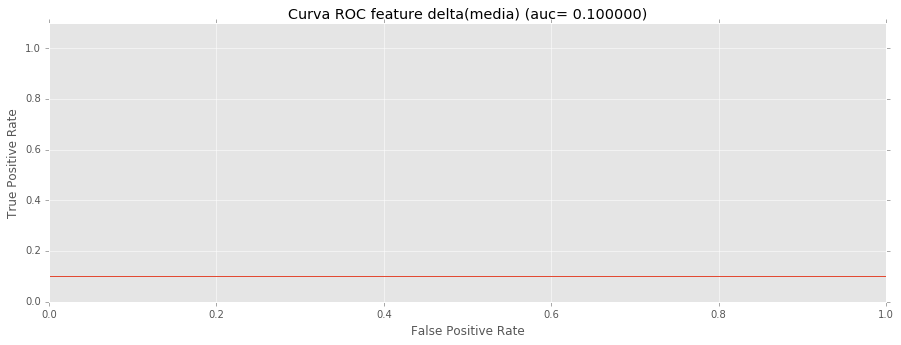

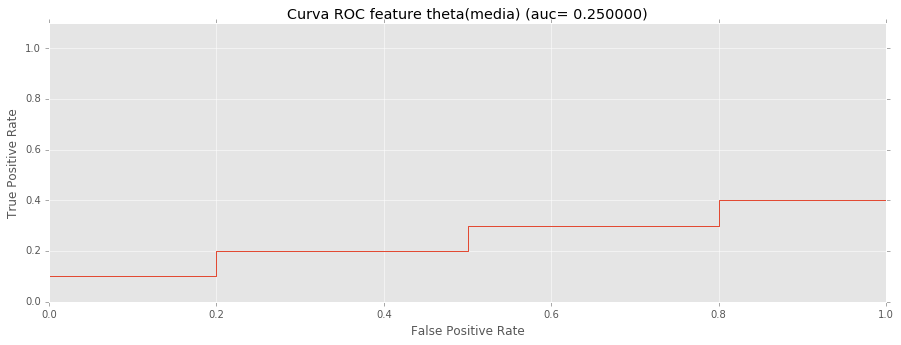

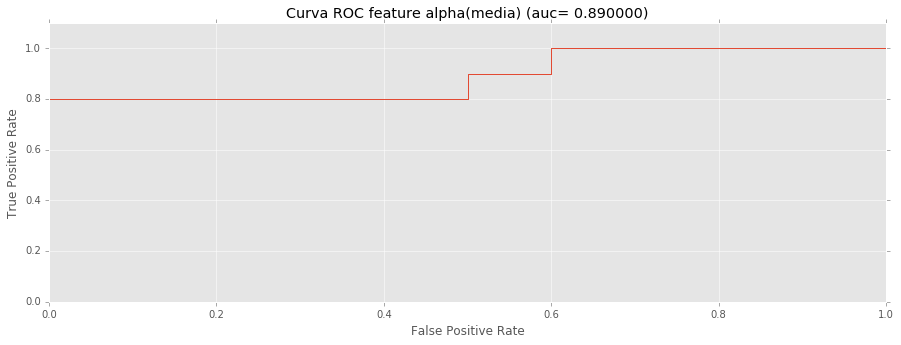

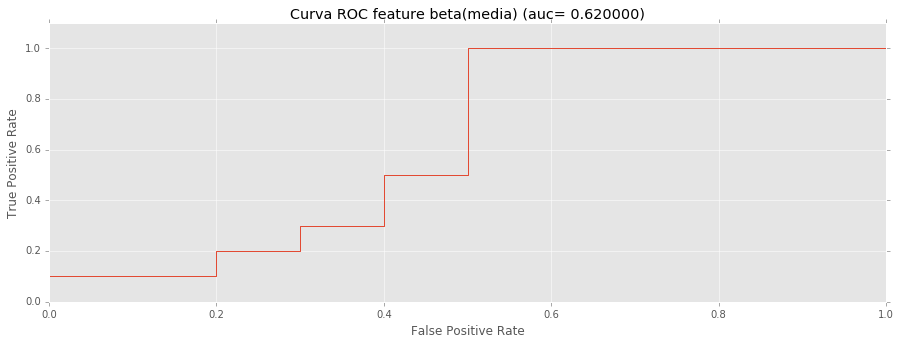

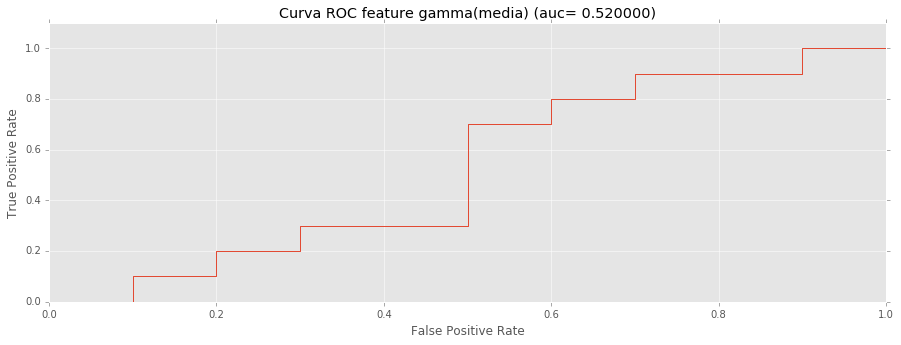

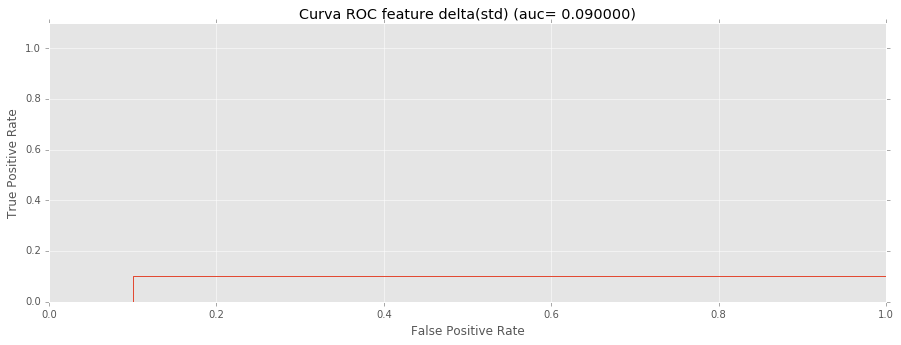

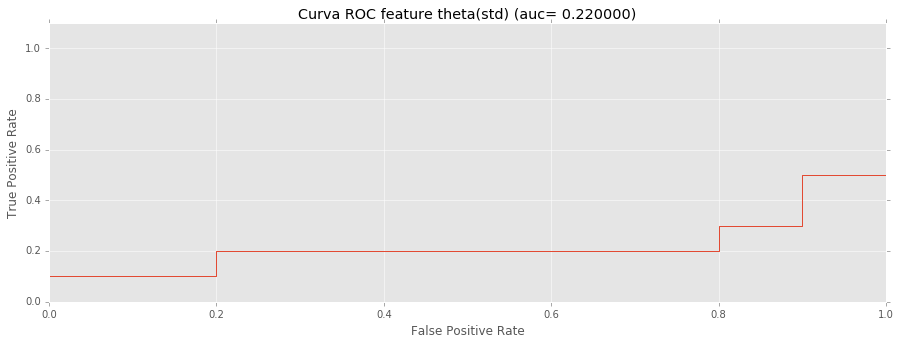

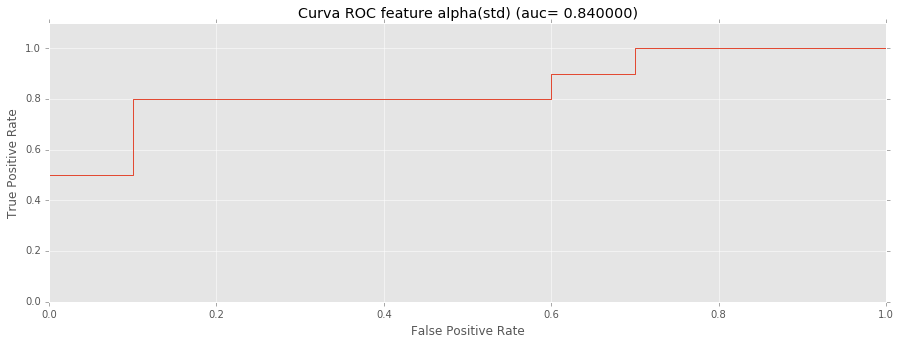

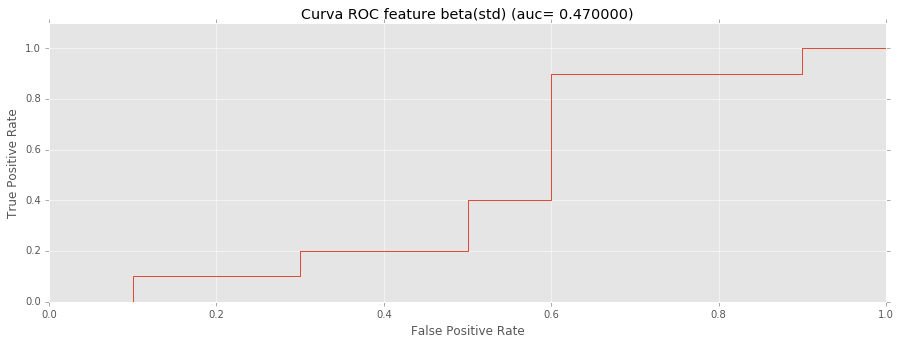

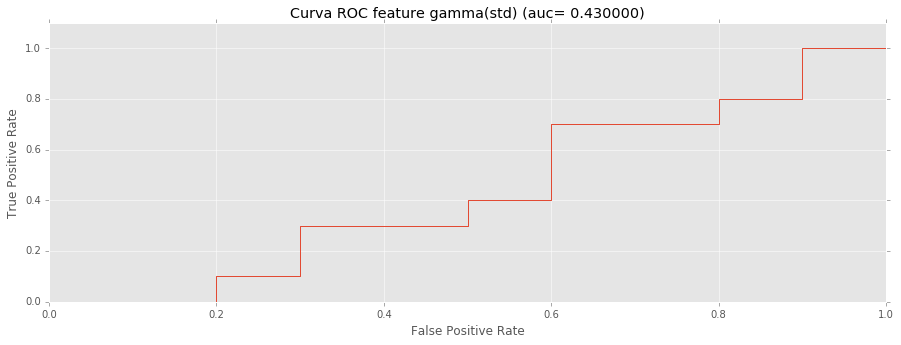

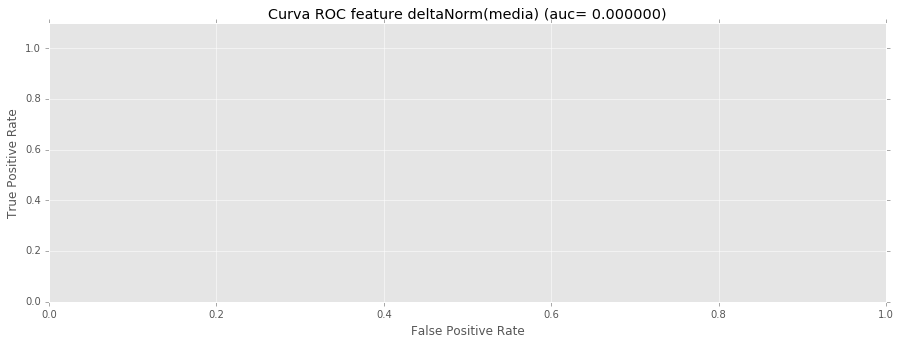

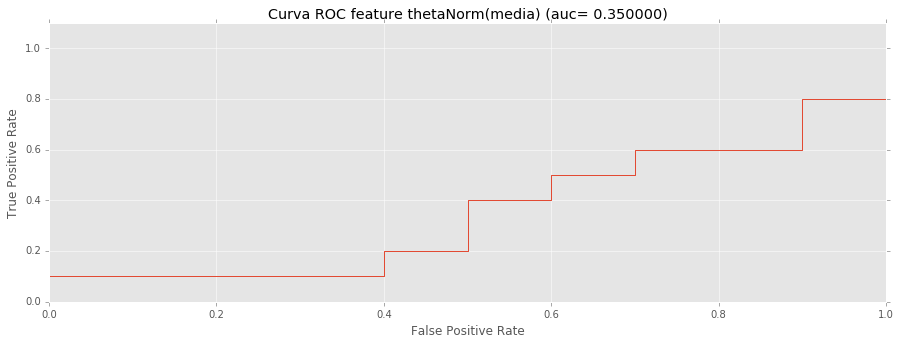

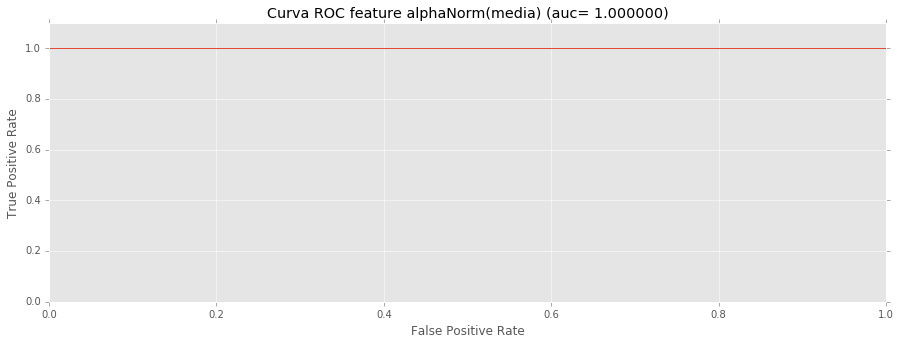

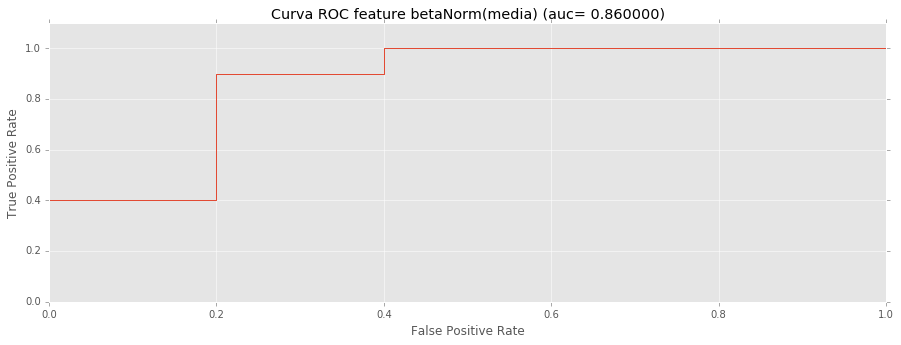

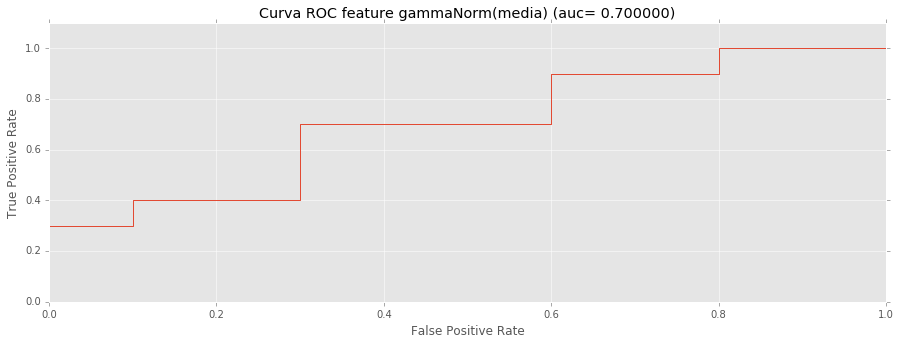

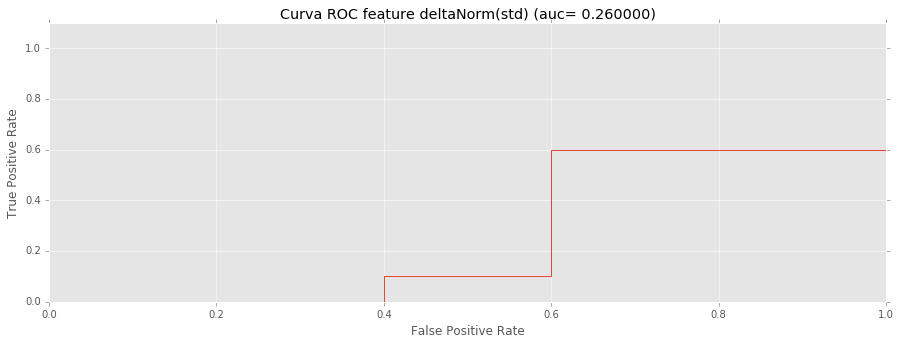

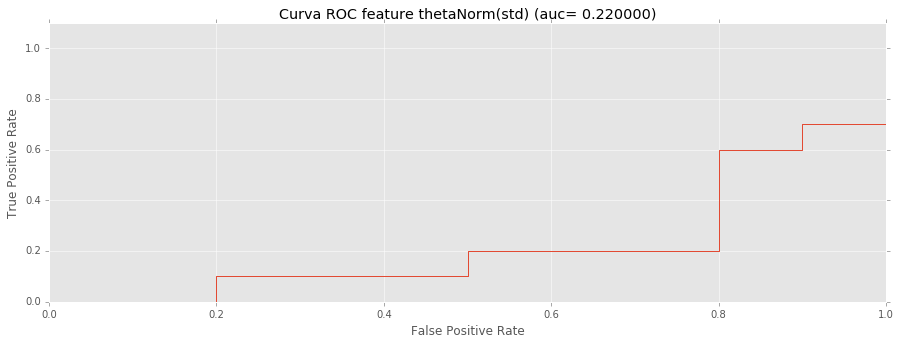

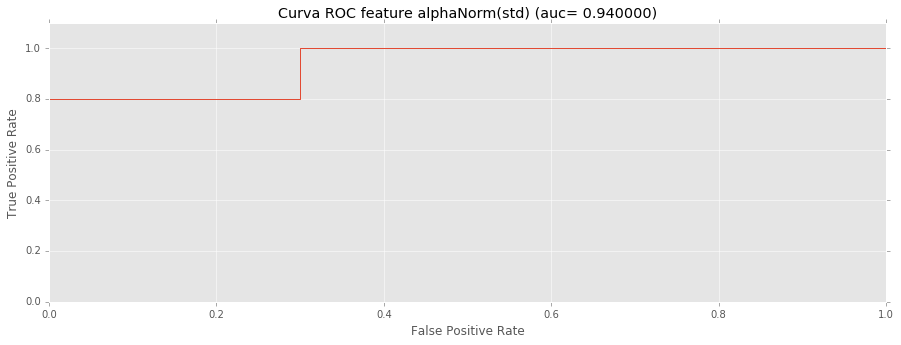

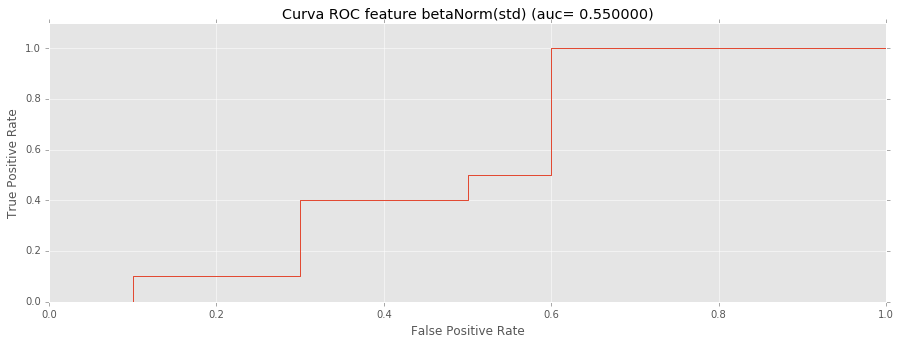

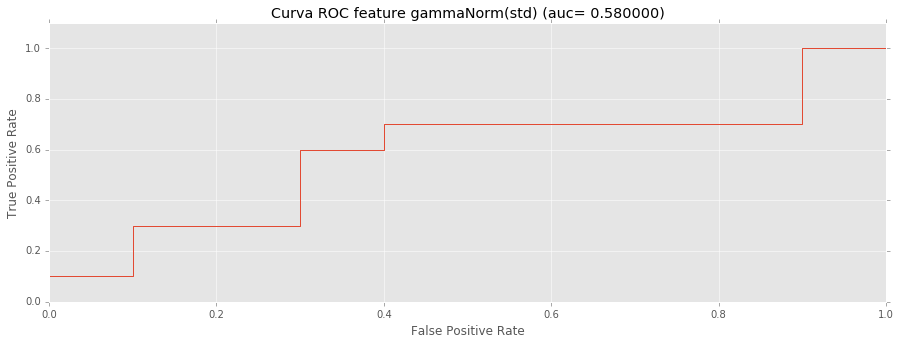

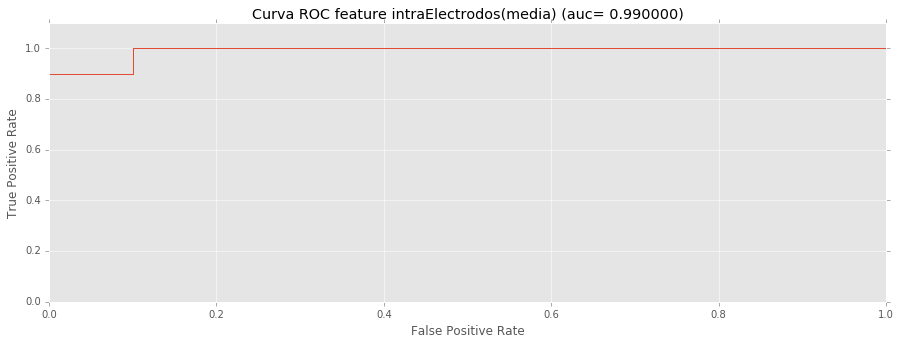

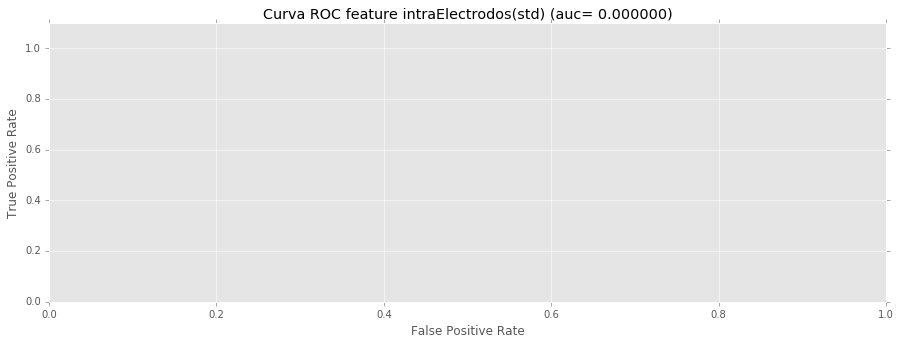

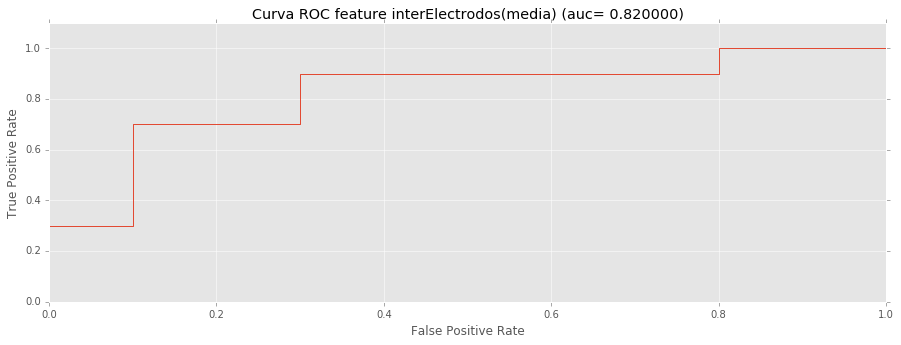

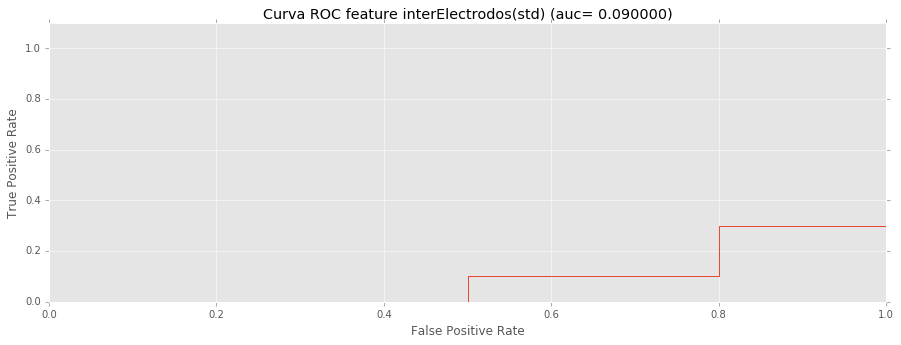

In [34]:
aucPorFeature = {}

for f in xrange(0,24):
    fpr, tpr, thresholds = roc_curve(target,  features[:,f]) # obtener la curva ROC
    plt.figure(figsize=(15, 5))
    plt.ylim(ymax=1.1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    area = auc(fpr, tpr)
    featureName = getFeatureName(f)
    plt.title("Curva ROC feature %s (auc= %f)" % (featureName,area))
    plt.plot(fpr,tpr) # plotear curva ROC
    plt.show()
    aucPorFeature[featureName] = area

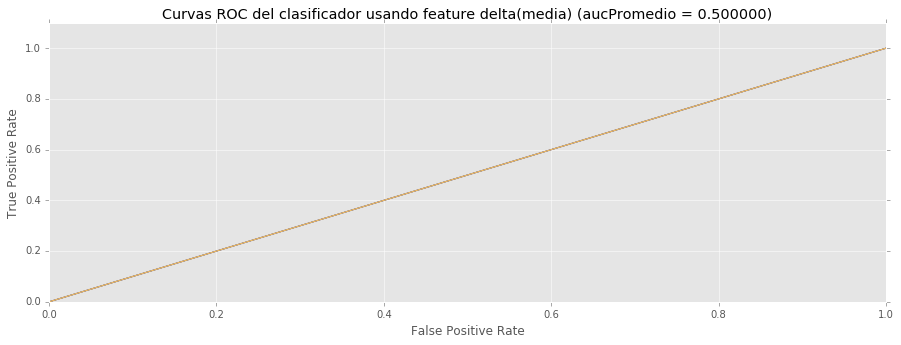

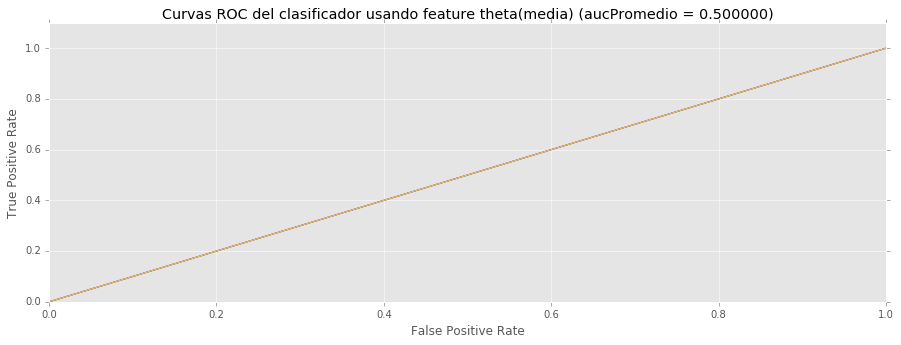

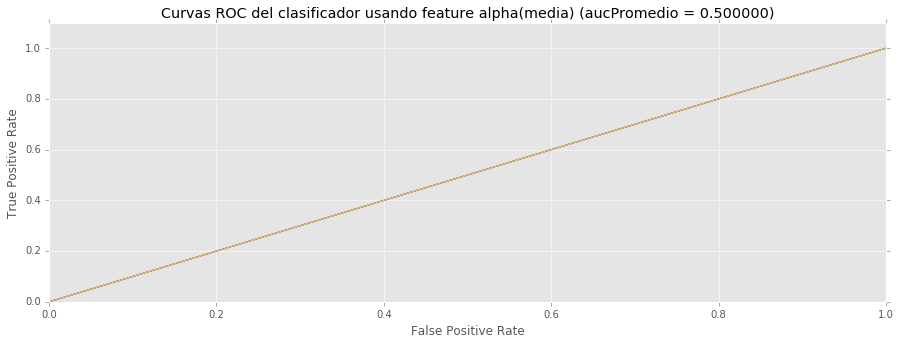

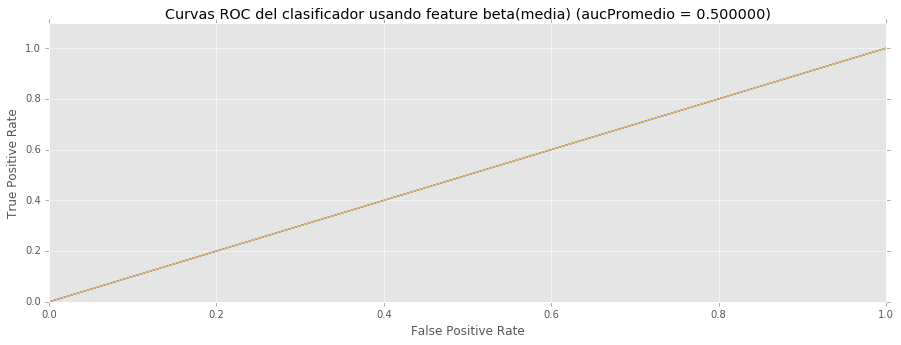

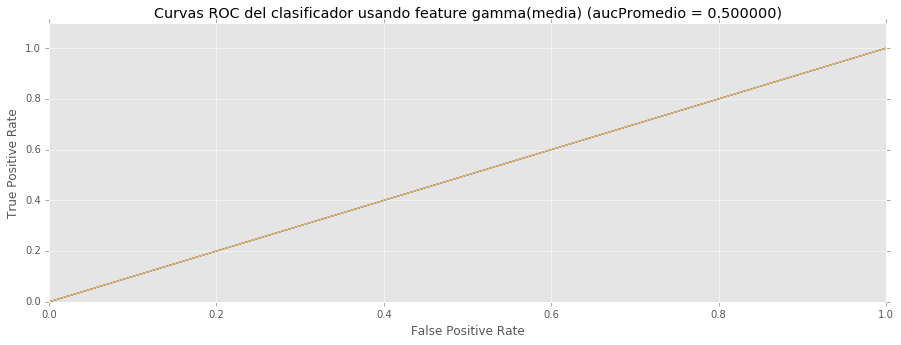

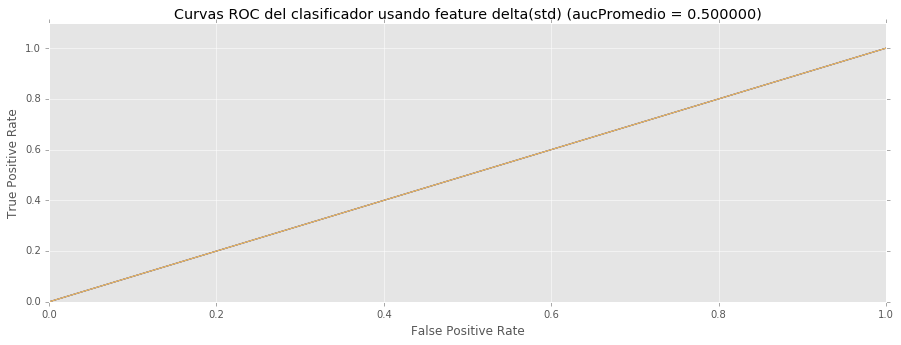

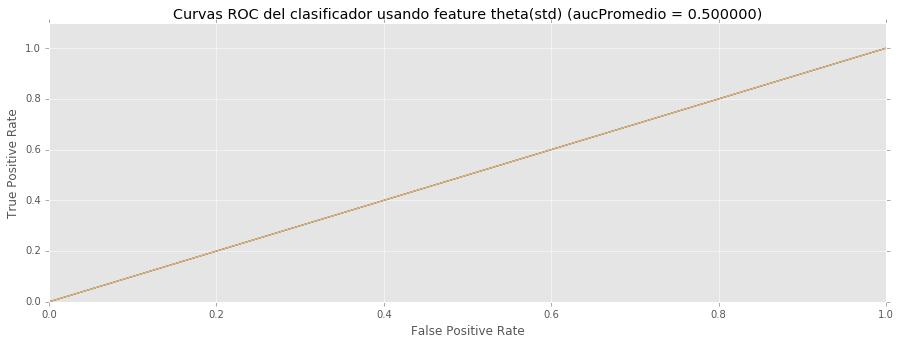

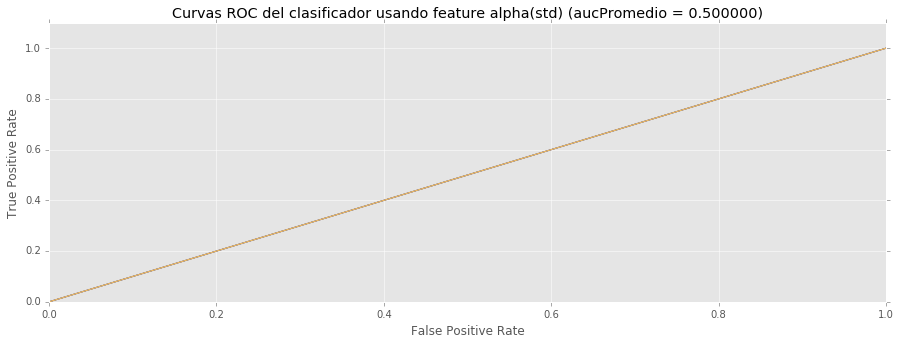

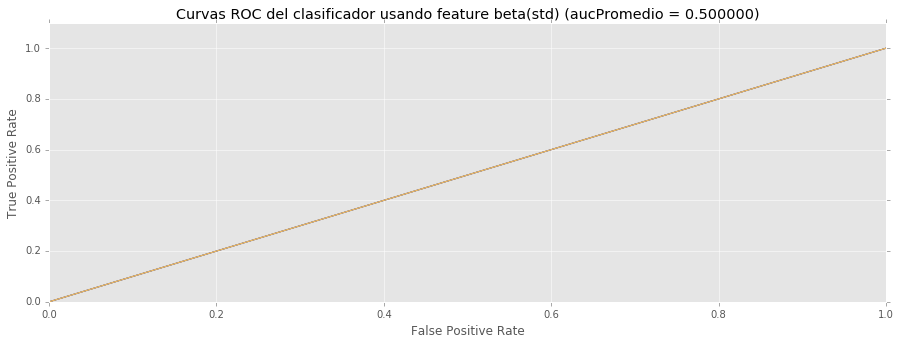

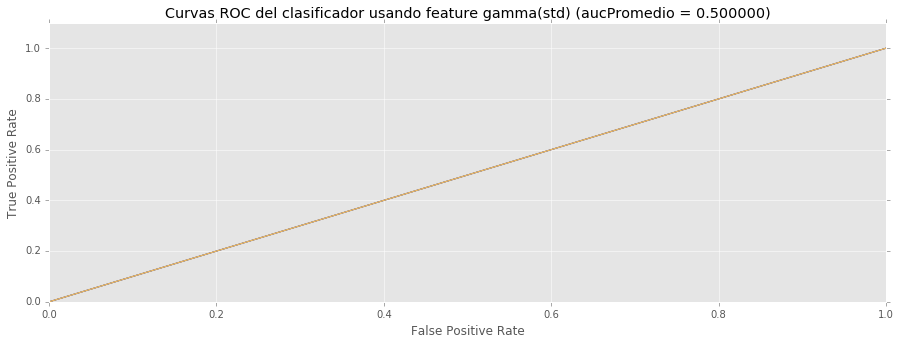

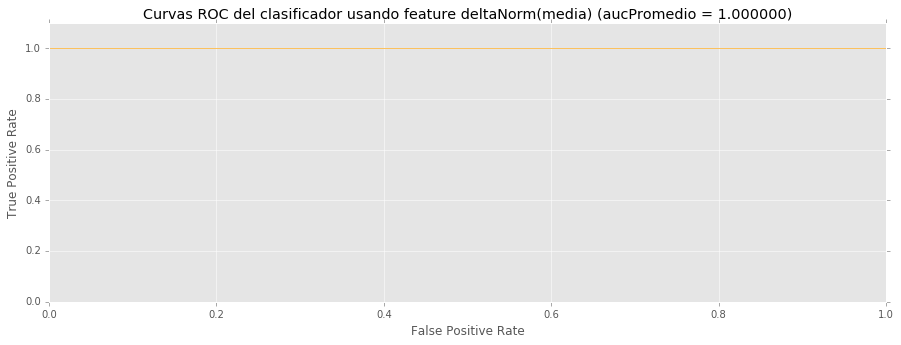

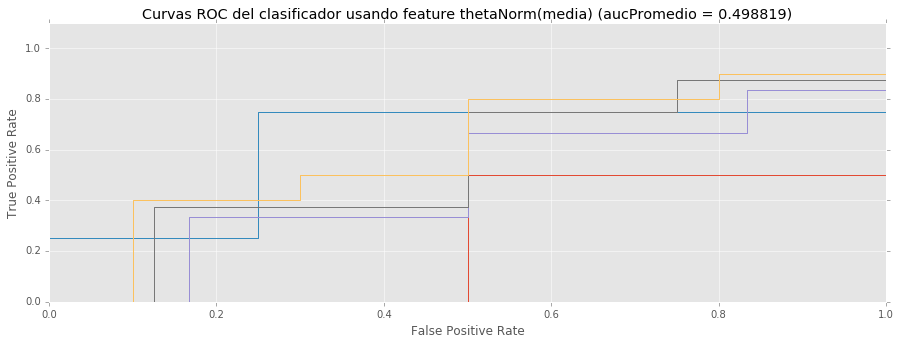

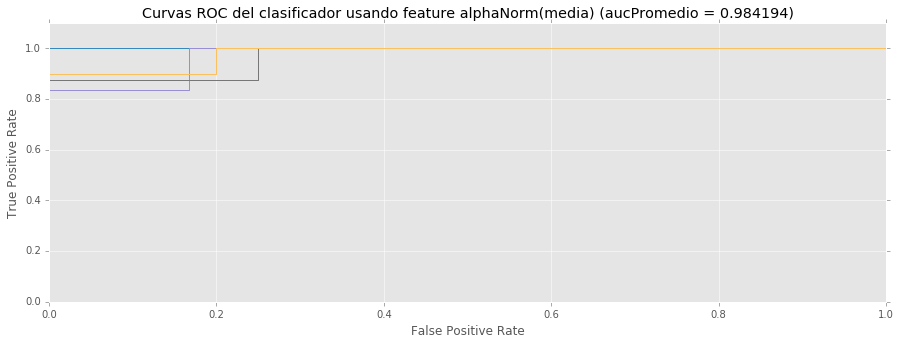

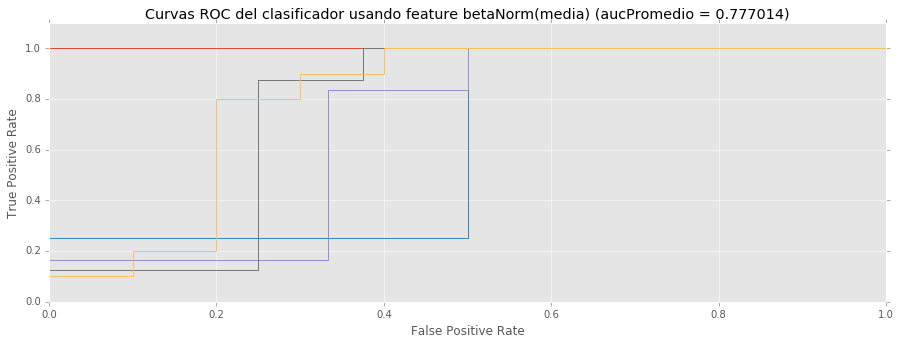

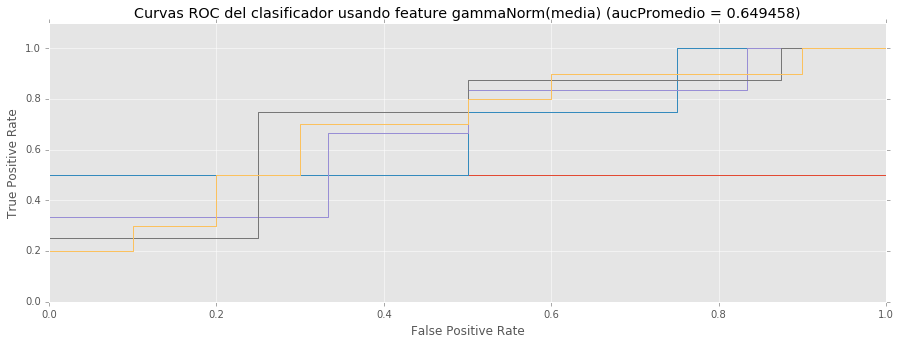

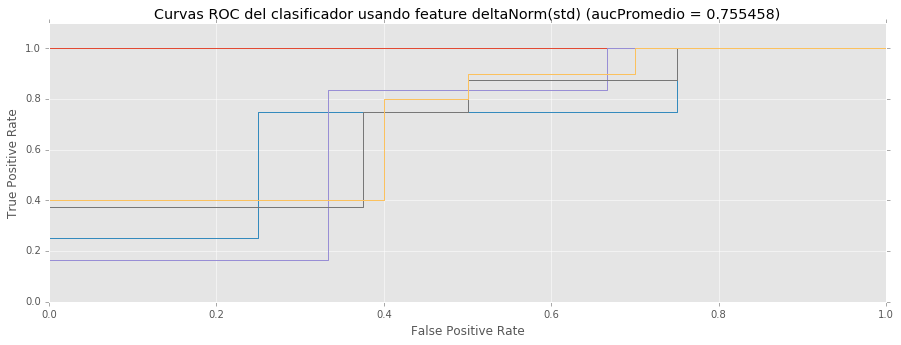

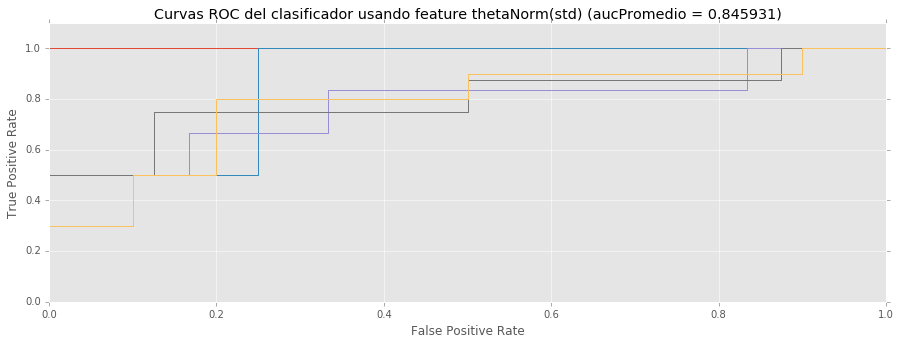

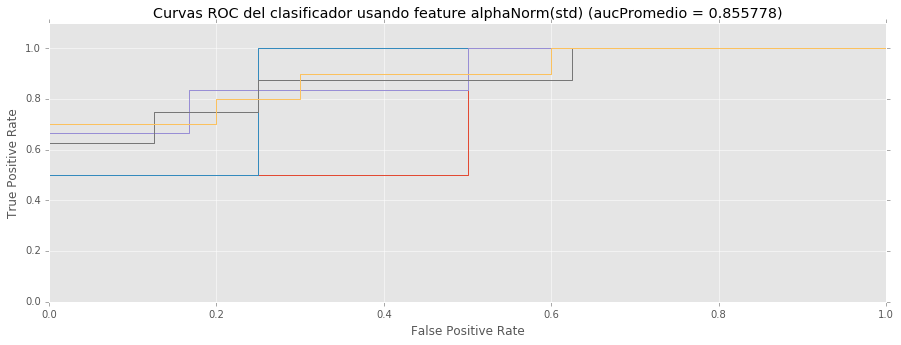

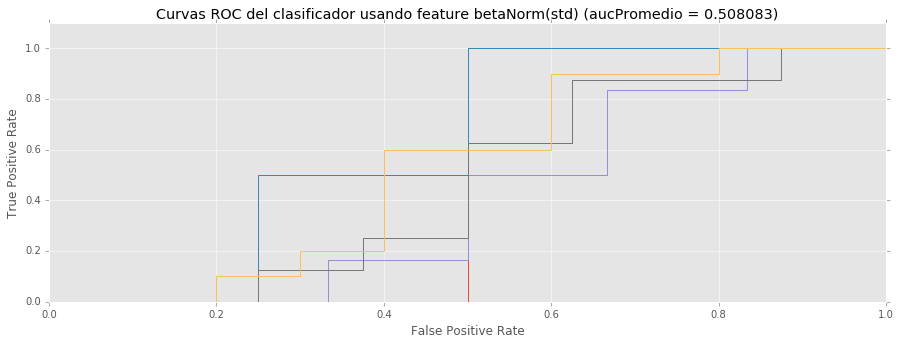

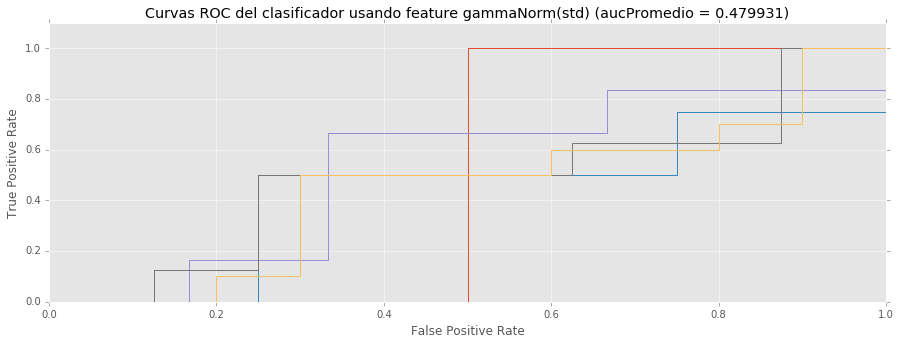

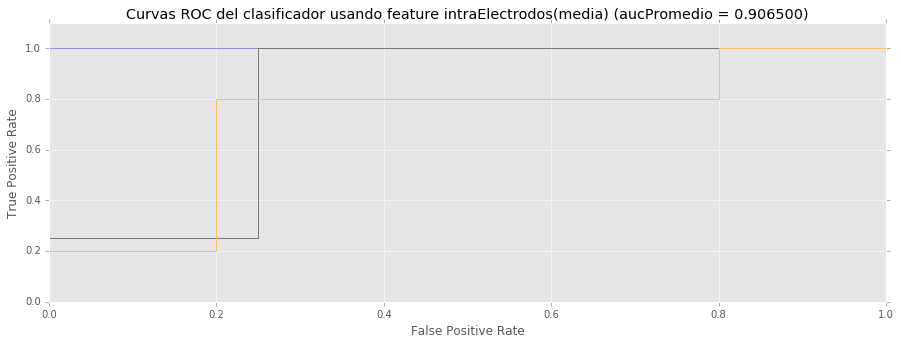

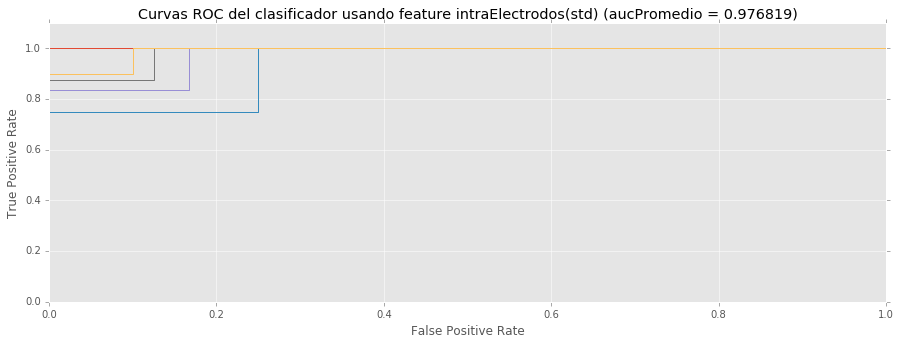

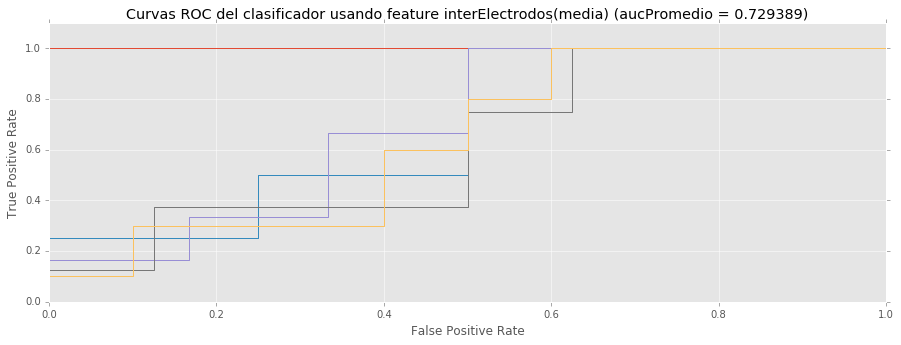

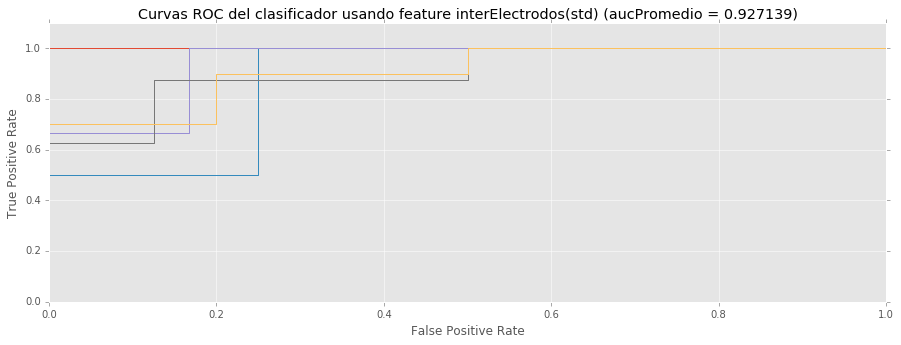

In [35]:
n_folds = 5
aucPorFeature = {}

for f in xrange(0,24):
    featureName = getFeatureName(f)
    plt.figure(figsize=(15, 5))
    plt.ylim(ymax=1.1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    areaPromedio = 0
    X = np.array(features[:,f]) # array de features
    y = np.array(target) # labels

    cv = StratifiedKFold(n_splits=n_folds, shuffle=True)

    cv_target = np.array([])
    cv_prediction = np.array([])
    cv_probas = np.array([])

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = X_train.reshape(-1, 1)
        X_test = X_test.reshape(-1, 1)

        clf = linear_model.LogisticRegression()
        clf = clf.fit(X_train,y_train)

        preds = clf.predict(X_test)
        probas = clf.predict_proba(X_test)

        cv_target = np.concatenate((cv_target, y_test), axis=0) # concatenar los resultados
        cv_prediction = np.concatenate((cv_prediction, preds), axis=0)
        cv_probas = np.concatenate((cv_probas, probas[:,1]), axis=0)

        preds_thr = np.zeros(len(cv_target))
        preds_thr[np.where(cv_probas>0.5)[0]] = 1
        cm = confusion_matrix(cv_target, preds_thr).astype(float)
        cm[0,:] = cm[0,:]/float(sum(cm[0,:])) # obtener matriz de confusion normalizada
        cm[1,:] = cm[1,:]/float(sum(cm[1,:]))

        fpr, tpr, thresholds = roc_curve(cv_target,  cv_probas) # obtener la curva ROC
        area = auc(fpr, tpr)
        areaPromedio = areaPromedio + area
        plt.plot(fpr,tpr) # plotear curva ROC
    areaPromedio = areaPromedio / n_folds
    aucPorFeature[featureName] = areaPromedio
    plt.title("Curvas ROC del clasificador usando feature %s (aucPromedio = %f)" % (featureName, areaPromedio))

Los mejores resultados de los clasificadores usando Regresión Logística se obtienen utilizando los features que corresponden a valores normalizados.

Esto es debido a que un feature en particular no normalizado, puede comportarse bastante mal en el caso de que no se encuentre con una distribución que se asemeje a una Gaussiana.

Muchos clasificadores con su función kernel toman a estos features como valores centrados en el 0
y con una varianza del mismo estilo.

Además, los features con mayor rendimiento se mantuvieron al utilizar el clasificador con Regresión Lineal, entre ellos se encuentran la media y el desvío estándar de la banda alpha (valores normalizados).

### Ejercicio 2 a)
En el siguiente ejercicio se entrenará un clasificador multivariado basado en SVM

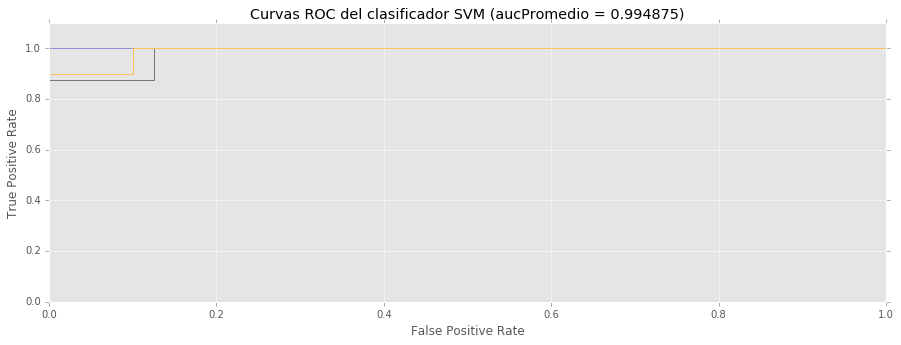

In [39]:
aucPromedio = 0
X = np.array(features) # features
y = np.array(target) # labels

n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True)
cv_target = np.array([])
cv_prediction = np.array([])
cv_probas = np.array([])

plt.figure(figsize=(15, 5))
plt.ylim(ymax=1.1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = svm.SVC(kernel='linear', C=1.0, probability=True)
    clf = clf.fit(X_train,y_train)

    preds = clf.predict(X_test)
    probas = clf.predict_proba(X_test)

    cv_target = np.concatenate((cv_target, y_test), axis=0) # concatenar los resultados
    cv_prediction = np.concatenate((cv_prediction, preds), axis=0)
    cv_probas = np.concatenate((cv_probas, probas[:,1]), axis=0)

    preds_thr = np.zeros(len(cv_target))
    preds_thr[np.where(cv_probas>0.5)[0]] = 1
    cm = confusion_matrix(cv_target, preds_thr).astype(float)
    cm[0,:] = cm[0,:]/float(sum(cm[0,:])) # obtener matriz de confusion normalizada
    cm[1,:] = cm[1,:]/float(sum(cm[1,:]))

    fpr, tpr, thresholds = roc_curve(cv_target,  cv_probas) # obtener la curva ROC
    area = auc(fpr, tpr)
    aucPromedio = aucPromedio + area
    plt.plot(fpr,tpr) # plotear curva ROC

aucPromedio = aucPromedio / n_folds
plt.title("Curvas ROC del clasificador SVM (aucPromedio = %f)" % aucPromedio)
plt.show()

### Ejercicio 2 b)

En el siguiente punto utilizaremos pipeline de Scikit-Learn para computar las 3 técnicas que nos pide el enunciado.



             precision    recall  f1-score   support

        0.0       1.00      0.75      0.86         4
        1.0       0.50      1.00      0.67         1

avg / total       0.90      0.80      0.82         5



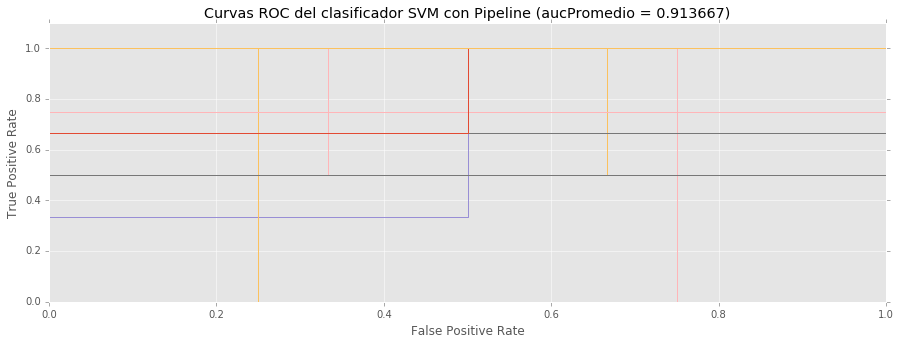

In [40]:
plt.figure(figsize=(15, 5))
plt.ylim(ymax=1.1)
aucPromedio = 0
niters = 1000

for i in xrange (1,niters):
    X = np.array(features) # features
    y = np.array(target) # labels
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    featureSelection = SelectPercentile(percentile=10)
    clf = svm.SVC(kernel='linear', probability=True)
    pipeline = make_pipeline(StandardScaler(), featureSelection, clf)

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    probas = pipeline.predict_proba(X_test)
    y_probas = probas[:,1]

    fpr, tpr, thresholds = roc_curve(y_test,  y_probas) # obtener la curva ROC
    aucPipeline = auc(fpr, tpr)
    if (not math.isnan(aucPipeline)):
        aucPromedio = aucPipeline + aucPromedio
    plt.plot(fpr,tpr) # plotear curva ROC

print(classification_report(y_test, y_pred))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC del clasificador SVM con Pipeline (aucPromedio = %f)" % (aucPromedio/niters))
plt.show()

Probamos utilizando un 20% de los features, para poder ver como varía el área de la curva Roc.

             precision    recall  f1-score   support

        0.0       0.50      1.00      0.67         1
        1.0       1.00      0.75      0.86         4

avg / total       0.90      0.80      0.82         5



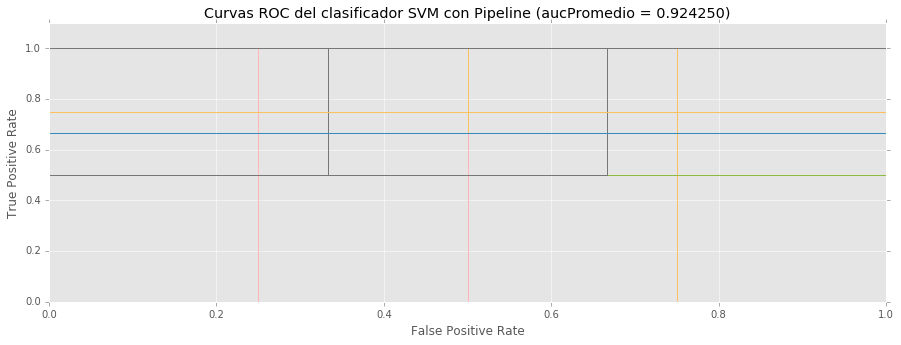

In [41]:
plt.figure(figsize=(15, 5))
plt.ylim(ymax=1.1)
aucPromedio = 0
niters = 1000

for i in xrange (1,niters):
    X = np.array(features) # features
    y = np.array(target) # labels
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    featureSelection = SelectPercentile(percentile=20)
    clf = svm.SVC(kernel='linear', probability=True)
    pipeline = make_pipeline(StandardScaler(), featureSelection, clf)

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    probas = pipeline.predict_proba(X_test)
    y_probas = probas[:,1]
       
    
    fpr, tpr, thresholds = roc_curve(y_test,  y_probas) # obtener la curva ROC
    aucPipeline = auc(fpr, tpr)
    if (not math.isnan(aucPipeline)):
        aucPromedio = aucPipeline + aucPromedio
    plt.plot(fpr,tpr) # plotear curva ROC

print(classification_report(y_test, y_pred))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC del clasificador SVM con Pipeline (aucPromedio = %f)" % (aucPromedio/niters))
plt.show()

Probamos con el 35 %

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00         1
        1.0       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00         5



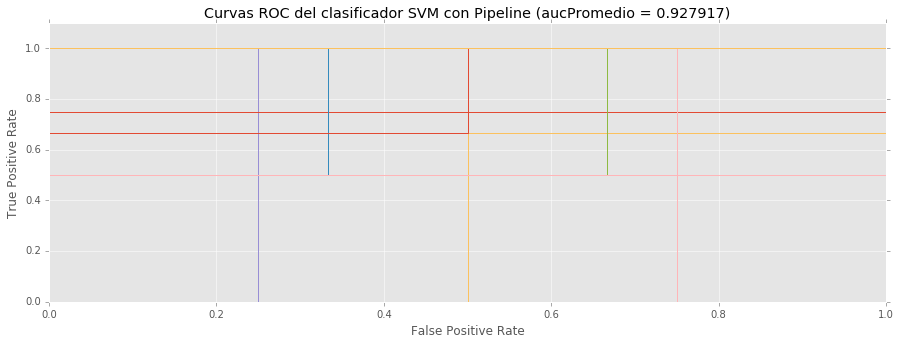

In [42]:
plt.figure(figsize=(15, 5))
plt.ylim(ymax=1.1)
aucPromedio = 0
niters = 1000

for i in xrange (1,niters):
    X = np.array(features) # features
    y = np.array(target) # labels
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    featureSelection = SelectPercentile(percentile=35)
    clf = svm.SVC(kernel='linear', probability=True)
    pipeline = make_pipeline(StandardScaler(), featureSelection, clf)

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    probas = pipeline.predict_proba(X_test)
    y_probas = probas[:,1]
       
    
    fpr, tpr, thresholds = roc_curve(y_test,  y_probas) # obtener la curva ROC
    aucPipeline = auc(fpr, tpr)
    if (not math.isnan(aucPipeline)):
        aucPromedio = aucPipeline + aucPromedio
    plt.plot(fpr,tpr) # plotear curva ROC

print(classification_report(y_test, y_pred))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC del clasificador SVM con Pipeline (aucPromedio = %f)" % (aucPromedio/niters))
plt.show()


Corriendo con un 20% de los features, luego de 1000 iteraciones, en promedio obtenemos una mejor curva roc, obteniendo así un auc mayor.

Esto se debe a una mayor caracterización de los individuos, al contar con más features de entrenamiento, tenemos mayor conocimiento de cada elemento a clasificar. Sin embargo, como estamos seleccionando los features con mayores scores, si aumentamos la cantidad de features seleccionados, llegará un momento en que incluiremos features con poca importancia que sólo volverán menos performante a nuestro clasificador o no generarán diferencias significativas, por lo que no vemos diferencias significativas al usar 35% de los features.
